# Free Energy Calculation Using NCE and Normalizing Flows

Define our energy function to be:

$$V(x) = \frac{p^2}{2m} + a_0x^4 - a_2x^2 + \alpha \sqrt{\frac{a_0}{2a_2}}x$$

Then the probability density of a particle existing at a point $x$ is:

$$p(x) = \frac{e^{- \beta V(x)}} {\int_{}^{} {e^{-\beta V(x)}dx}} $$

We use $p, a_0, a_2, m, \alpha, \beta  = (4, 2, 10, 10, 5, 0.2)$

In [1]:
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
torch.set_default_dtype(torch.float64)
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from sys import exit
import scipy.integrate as integrate
from scipy import optimize


from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform
from torch.nn import functional as F

In [2]:
def V_x(x, params=(4, 2, 10, 10, 5)):
    p, a0, a2, m, alpha = params[0], params[1], params[2], params[3], params[4]
    return (p**2)/(2*m) + a0*x**4 - a2*x**2 + alpha*np.sqrt(a0/(2*a2))*x

V_x_np = np.vectorize(V_x)

Z = dict()

def p_x(x, range_=(-10, 10), beta=0.2, params=(4, 2, 10, 10, 5)):
    E = V_x(x, params)
    Z0 = 22.7182312156

    if (x < range_[0]) or (x > range_[1]):
        return 0
    
    lower, upper = range_[0], range_[1]

    try:
        Z0 = Z[(beta, params, range_)]
    except:
        Z0 = integrate.quad(lambda x: np.exp(-beta*V_x(x, params)), lower, upper)[0]
        Z[(beta, params, range_)] = Z0
        
    return np.exp(-beta*E)/Z0

params = (4, 2, 10, 10, 5)
beta = 0.2

Below we can plot the two functions.

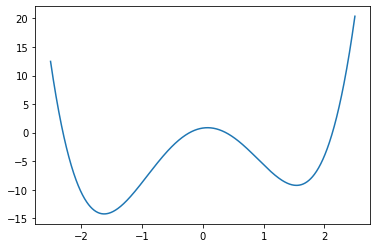

In [3]:
lines = np.linspace(-2.5, 2.5, 1000)
V_x_curve = [V_x(x) for x in lines]
plt.plot(lines, V_x_curve)

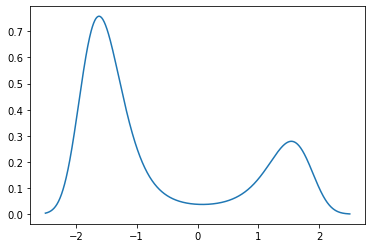

In [4]:
lines = np.linspace(-2.5, 2.5, 1000)
p_x_curve = [p_x(x) for x in lines]
plt.plot(lines, p_x_curve)

# Sample From Overall Distribution Using MCMC

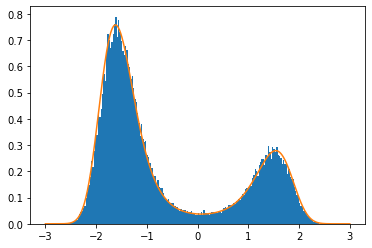

In [5]:
def metropolis_hastings(target_density, range0 = None, size=300000):
    burnin_size = 100000
    size += burnin_size

    x0 = 0
    xt = x0

    samples = []

    lower, upper = range0[0], range0[1]

    for i in range(size):
        xt_candidate = np.array([np.random.normal(0, 4)])

        if range0 == None:
            accept_prob = (target_density(xt_candidate))/(target_density(xt))
        #fix this shitty code
        else:
            if (xt_candidate < lower) or (xt_candidate > upper):
                accept_prob = 0
            else:
                accept_prob = (target_density(xt_candidate))/(target_density(xt))

        if np.random.uniform(0, 1) < accept_prob:
            xt = xt_candidate
        samples.append(xt)

    samples = np.array(samples[burnin_size:])
    return samples

#https://stackoverflow.com/questions/21100716/fast-arbitrary-distribution-random-sampling-inverse-transform-sampling
samples = metropolis_hastings(p_x, range0 = (-100, 100))

lines = np.linspace(-3, 3, 1000)
normal_curve = [p_x(l) for l in lines]
dist = samples
plt.hist(dist, density=1, bins=200) 
plt.plot(lines, normal_curve)

## Calculate Free Energy Using Sampling or Integration

Here, we are interesting in the free energy going from state A to B. This should be a positive quantity since there is lower probability of being in state B versus state A. Using itegration, the free energy difference is:

$$-\frac{1}{\beta} \cdot \ln \frac{\int_{ \ 0}^{5} p(x)dx}{\int_{-5}^{ \ 0} p(x)dx }$$

By counting, it would be:

$$-\frac{1}{\beta} \cdot \ln \frac{N_B}{N_A}$$

In [6]:
B = integrate.quad(p_x, 0, 5)[0]
A = integrate.quad(p_x, -5, 0)[0]

benchmark_f = -1/beta*np.log(B/A)
print(benchmark_f)

N_A, N_B = 0, 0
for x_i in samples:
    if -10 < x_i < 0:
        N_A += 1
    if 0 < x_i < 10:
        N_B += 1

print(-1/beta*np.log(N_B/N_A))

4.440506233920195
4.416123205100914


## Sample From Basin A and Basin B Using MCMC

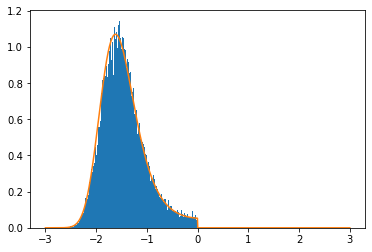

In [7]:
samplesA = metropolis_hastings(p_x, range0 = (-10, 0))
linesA = np.linspace(-3, 3, 1000)
curveA = [p_x(x, (-10, 0), beta, params) for x in lines]
dist = samplesA
plt.hist(dist, density=1, bins=200) 
plt.plot(linesA, curveA)

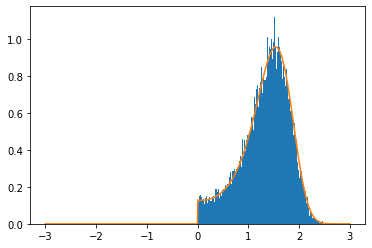

In [8]:
samplesB = metropolis_hastings(p_x, range0 = (0, 10))
linesB = np.linspace(-3, 3, 1000)
curveB = [p_x(x, (0, 10), beta, params) for x in lines]
dist = samplesB
plt.hist(dist, density=1, bins=200) 
plt.plot(linesB, curveB)

## Learn Potential Energy Function From Samples

In [9]:
class NCE(nn.Module):
    def __init__(self, noise_dist):
        super(NCE, self).__init__()

        self.U_x = nn.Sequential(
          nn.Linear(1, 30),
          nn.Tanh(),
          nn.Linear(30, 100),
          nn.Tanh(),
          nn.Linear(100, 30),
          nn.Tanh(),
          nn.Linear(30, 1),
        )
        
        self.beta = 0.2
        self.ln_Z = 1

        self.noise_dist = noise_dist

    def forward(self, x):
        return -self.beta*self.U_x(x) - self.ln_Z
        
    def ln_p_m(self, x): #this is U(x)
        #print(x[0])
        return -self.beta*self.U_x(x) - self.ln_Z
    
    def ln_p_n(self, x):
        #print(x[0])
        return self.noise_dist.log_prob(x.to(device)).to(device)
    
    def G_x_theta(self, x):
        #print(x[0])
        return self.ln_p_m(x) - self.ln_p_n(x)

    def h_x_theta(self, x):
        #print(x[0])
        return torch.sigmoid(self.G_x_theta(x))
    
    def loss(self, X_true, Y_true):
        T = X_true.size()[0] + Y_true.size()[0]
        J_T_vec = torch.log(self.h_x_theta(X_true)) + torch.log(1 - self.h_x_theta(Y_true)).to(device)
        return -(1/(2*T))*torch.sum(J_T_vec)

In [10]:
device = torch.device("cpu")
samplesA = torch.tensor(samplesA).to(device)
samplesB = torch.tensor(samplesB).to(device)
samples = torch.tensor(samples).to(device)
modelA = NCE(Uniform(-3, 0)).to(device)
optimizerA = optim.Adam(modelA.parameters(), lr=0.5*1e-3)

In [11]:
def train(model, optimizer, true_samples):
    model.train()
    train_loss = 0

    #true_samples = true_samples.to(device)
    #noise_samples = noise_samples.to(device)
    
    t = true_samples
    n = model.noise_dist.sample( (1000, 1) ).to(device)

    optimizer.zero_grad()
    loss = model.loss(t, n)
    loss.backward()

    train_loss += loss.item()
    optimizer.step()

device = torch.device("cpu")

samplesA = torch.tensor(samplesA).to(device)
samplesB = torch.tensor(samplesB).to(device)
samples = torch.tensor(samples).to(device)

modelA = NCE(Uniform(-3, 0)).to(device)
optimizerA = optim.Adam(modelA.parameters(), lr=0.5*1e-3)


#train NCEmodelA
for iter in range(0, 10):
    for epoch in range(1, 300):
        train(modelA, optimizerA, samplesA[1000*epoch:1000*epoch+1000])

<ipython-input-11-0a74459a513b>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  samplesA = torch.tensor(samplesA).to(device)
<ipython-input-11-0a74459a513b>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  samplesB = torch.tensor(samplesB).to(device)
<ipython-input-11-0a74459a513b>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  samples = torch.tensor(samples).to(device)


<ipython-input-12-0e15f59729fb>:4: RuntimeWarning: divide by zero encountered in log
  U_x_curve_0 = [-1/beta*np.log(p_x(l, range_=(-3,0))) for l in lines]


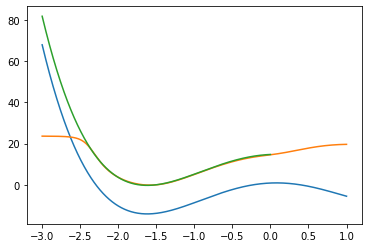

In [12]:
lines = np.linspace(-3, 1, 1000)
U_x_curve_true = [V_x(l) for l in lines]
U_x_curve = [-1/beta*(modelA(torch.tensor(l).reshape(1,1).to(device))).cpu().detach().numpy()[0][0] for l in lines]
U_x_curve_0 = [-1/beta*np.log(p_x(l, range_=(-3,0))) for l in lines]

plt.plot(lines, U_x_curve_true)
plt.plot(lines, U_x_curve)
plt.plot(lines, U_x_curve_0)

# Train Model B

In [13]:
modelB = NCE(Uniform(0, 3)).to(device)
optimizerB = optim.Adam(modelB.parameters(), lr=0.5*1e-3)

for iter in range(0, 10):
    for epoch in range(1, 300):
        train(modelB, optimizerB, samplesB[1000*epoch:1000*epoch+1000])

<ipython-input-14-7d6b5374610e>:4: RuntimeWarning: divide by zero encountered in log
  U_x_curve_0 = [-1/beta*np.log(p_x(l, range_=(0, 3))) for l in lines]


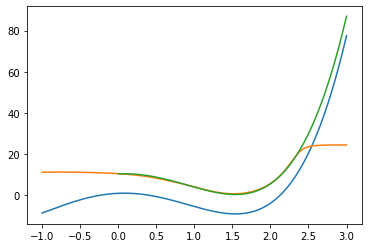

In [14]:
lines = np.linspace(-1, 3, 1000)
U_x_curve_true = [V_x(l) for l in lines]
U_x_curve = [-1/beta*(modelB(torch.tensor(l).reshape(1,1).to(device))).cpu().detach().numpy()[0][0] for l in lines]
U_x_curve_0 = [-1/beta*np.log(p_x(l, range_=(0, 3))) for l in lines]

plt.plot(lines, U_x_curve_true)
plt.plot(lines, U_x_curve)
plt.plot(lines, U_x_curve_0)

In [15]:
def E_A(x):
    return (modelA(torch.tensor(x).reshape(len(x),1).to(device))).cpu().detach().numpy()

def E_B(x):
    return (modelB(torch.tensor(x).reshape(len(x),1).to(device))).cpu().detach().numpy()

## DeepEXP

Free energy perturbation theory states (some times called exponential averaging and abbreviated EXP):

$$\langle e^{-\beta \Delta E} \rangle_A = e^{-\beta \Delta F} \implies \Delta F = \frac{-1}{\beta} \ln \langle e^{-\beta \Delta E} \rangle_A $$

In our case, we can estimate the free energy difference between region $A$ and $B$.

Consider that the above equation can be rewritten as 

$$\frac{-1}{\beta} \cdot \ln \int p(x) e^{-\beta \Delta U(q)} dx$$

Consider that our samples are already representative of $p(x)$

In [16]:
#samplesA =
#samplesB =

F_abs_A = (-1/beta)*np.log(np.sum(np.exp(-beta*(E_A(samplesA)-V_x_np(samplesA)))))
F_abs_B = (-1/beta)*np.log(np.sum(np.exp(-beta*(E_B(samplesB)-V_x_np(samplesB)))))

print(F_abs_B-F_abs_A)
print(F_abs_A-F_abs_B)
percenterror = np.abs(((F_abs_A-F_abs_B) - benchmark_f)/ benchmark_f)

print(benchmark_f)

print(percenterror)


<ipython-input-15-2326a8dad83a>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (modelA(torch.tensor(x).reshape(len(x),1).to(device))).cpu().detach().numpy()
<ipython-input-15-2326a8dad83a>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (modelB(torch.tensor(x).reshape(len(x),1).to(device))).cpu().detach().numpy()


-4.555437245983519
4.555437245983519
4.440506233920195
0.02588241205144304
